In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *

In [2]:
def integrate_setup(N, g, J):
    # Create pauli matrices
    si = qeye(2)
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    # Create lists for the operators and wf
    op_list = []
    wf_list = []
    
    # Define basis for wf
    wf = basis(2, 1)
    
    # Fill lists so that we can create the full tensor
    for m in range(N):
        wf_list.append(wf)
    
    # Create full tensor
    wf_tensor = tensor(wf_list)
    
    # Construct lists for the x and z Paulis
    sx_list = []
    sz_list = []

    # Normalize wf tensor
    init = wf_tensor.unit()
    
    # Construct different combinations of Paulis for the Hamiltonian
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N-1):
        H += -J * sz_list[n] * sz_list[n+1]
        for m in range(N):
            H += -J * g * sx_list[n]

    #E_0 = H.eigenenergies(eigvals=1)[0]
    E, V = linalg.eigh(H.data.toarray())
    print(E[0])

    if E[0] < 0:
        H -= 1.5 * E[0]
        # H=(2**N)*H/H.tr()
    print(J, g)

    print("Hamiltonian and dissipators constructed.")
    print("Shape of H is {}, and Hermitian check returned {}".format(H.shape,H.isherm))
    
    return H, sz_list, sx_list, init

In [3]:
def forward_step(H, wf, dt):
    U = (1j * H * np.sqrt(dt)).expm()
    wf_new = U * wf
    return wf_new.unit()

In [4]:
def construct_op_lists(num_qubits):
    """
    function to create the lists of tensored operators we use
    :param num_qubits: the number of qubits in the system
    :returns:          lists of the full z and x operators
    """
    z_list = []
    x_list = []
    for i in range(num_qubits):
        z_list.append((I ^ i) ^ Z ^ (I ^ (num_qubits - 1 - i)))
        x_list.append((I ^ i) ^ X ^ (I ^ (num_qubits - 1 - i)))
        
    return z_list, x_list

In [5]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Set up parameters

In [6]:
# Define system parameters
N = 2
g = 2
j = 1

In [7]:
# Set up parameters for unitary
beta = 0.2
numsteps = 500
betas, dt = np.linspace(0, beta, numsteps, retstep=True)

## Classical Calculation

In [8]:
# initialize some stuff
H, sz_list, sx_list, wf_init = integrate_setup(N, g, j)
U = (1j * H * np.sqrt(dt / 2)).expm()

-4.123105625617657
1 2
Hamiltonian and dissipators constructed.
Shape of H is (4, 4), and Hermitian check returned True


In [9]:
wf_root_list = [wf_init]
overlap_list = [wf_init.overlap(wf_init)]
E_overlap_list = [(H * wf_init).overlap(wf_init)]
sx_overlap_list = [(sx_list[0] * wf_init).overlap(wf_init)]

# Perform propagation
for _ in range(len(betas) - 1):
    # Propagate wf forward in time one step
    wf_root_list.append(forward_step(H / np.sqrt(2), wf_root_list[-1], dt))

    # Propagate wf backward in time one step
    wf_root_list.insert(0, forward_step(-H / np.sqrt(2), wf_root_list[0], dt))

    # Calculate overlaps of most future and most past wfs and append to lists
    overlap_list.append(2 * (wf_root_list[0].overlap(wf_root_list[-1])).real)
    E_overlap_list.append(2 * (H * wf_root_list[0]).overlap(wf_root_list[-1]).real)
    sx_overlap_list.append(2 * (sx_list[0] * wf_root_list[0]).overlap(wf_root_list[-1]).real)

In [10]:
partition_list = [1]
E_class = [E_overlap_list[0]]
sx_expect = [sx_overlap_list[0]]
for m in range(3, numsteps, 2):
    partition = 0
    E = 0
    s = 0
    for k in range(0, m, 2):
        partition += binom(m, int(k/2)) * overlap_list[m-k]
        E += binom(m, int(k/2)) * E_overlap_list[m-k]
        s += binom(m, int(k/2)) * sx_overlap_list[m-k]
    
    partition = np.abs(partition)
    partition_list.append(partition)
    E_class.append(E/partition)
    sx_expect.append(s/partition)

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


2.061552812808826


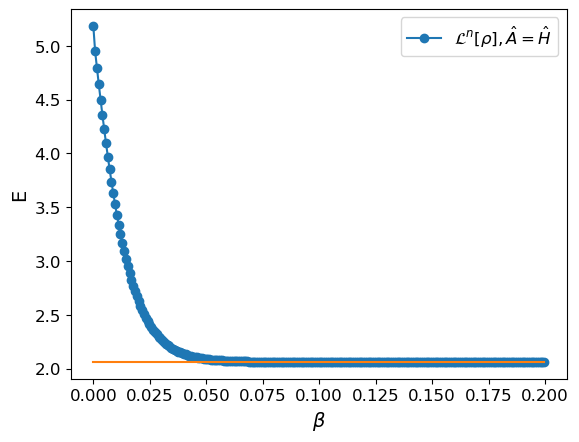

In [11]:
E, V = H.eigenstates()
plt.plot(betas[::2], E_class, 'o-', label='$\\mathcal{L}^n[\\rho],\hat{A}=\hat{H}$')
plt.plot(betas[::2], E[0] * np.ones(len(E_class)))
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend(numpoints=1)
print(E[0])

## Qiskit Statevector

In [12]:
# Want to check that this is the same initial wavefunction
# Ctreate initial wavefunction
wf_qis_init = [[0 + 0*1j] for i in range(2 ** N)]
wf_qis_init[-1] = [1+0*1j]

# Check that its the same as classical approach
print(np.allclose(wf_init.data.toarray(), wf_qis_init))

# But not useful for qiskit
wf_qis_init = [0 + 0*1j for i in range(2 ** N)]
wf_qis_init[-1] = 1+0*1j

True


In [13]:
z_ops , x_ops = construct_op_lists(N)

for i in range(N):
    print(
        np.allclose(
                x_ops[i].to_matrix(), sx_list[i].data.toarray()
            )
         )
    print(
        np.allclose(
                z_ops[i].to_matrix(), sz_list[i].data.toarray()
            )
         )
    

True
True
True
True


1 2
H = H_qis ?  True
H = H_qut ?  True


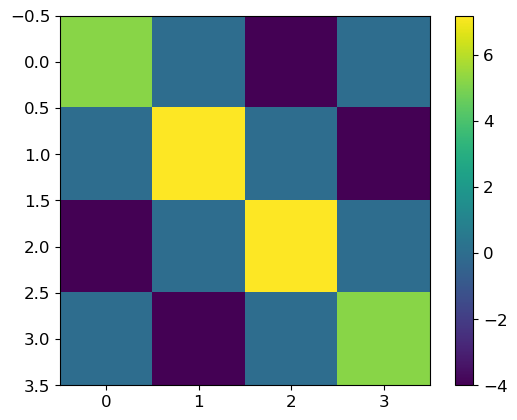

In [14]:
# Want to check that this approach creates the same H as the integrate_setup
# Loop over sites to construct parts of H
print(j, g)
H_qis = 0
H_qut = 0
for n in range(N-1):
    H_qis += -j * z_ops[n] @ z_ops[n+1]
    H_qut += -j * sz_list[n] * sz_list[n+1]
    for m in range(N):
        H_qis += -j * g * x_ops[n]
        H_qut += -j * g * sx_list[n]

# Get eigenenergies from H
E_qut, V_qut = linalg.eigh(H_qut.data.toarray())
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

# Scale H down to avoid having a negative ground energy
H_qis -= 1.5 * E_qis[0] * (I ^ I)
H_qut -= 1.5 * E_qut[0]

# Get new eigenvalues and vectors
E_qut, V_qut = linalg.eigh(H_qut.data.toarray())
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

# Check that its the same
print("H = H_qis ? ", np.allclose(H.data.toarray(), H_qis.to_matrix()))
print("H = H_qut ? ", np.allclose(H_qut.data.toarray(), H.data.toarray()))

# Plot for edification
plt.figure(1)
plt.imshow(H.data.toarray().real)
plt.colorbar()

In [15]:
# Create unitary with parameter for time evolution
U_f = (float(np.sqrt(dt/2)) * H_qis).exp_i().to_instruction()
#U_f = linalg.expm(1j * np.sqrt(dt / 2) * H_qis.to_matrix())
#U_b = linalg.expm(-1j * np.sqrt(dt / 2) * H_qis.to_matrix())
U_b = (-float(np.sqrt(dt/2)) * H_qis).exp_i().to_instruction()

# Check that this U_f is the same as in classical approach
#print(np.allclose(U.data.toarray(), U_f))

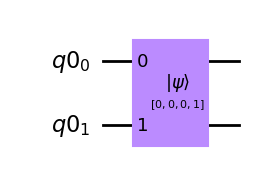

In [16]:
# Idea is to simulate the evolution in two step intervals
# For the statevector simulator, we don't need to worry about implementing the obs we want to
# measure because we can get the state directly
# Ultimately, we'll need two circuits - one for the forward direction and one for backward

# Create forward circuit and initialize to wf_init
qr = QuantumRegister(N)
for_circ = QuantumCircuit(qr)
for_circ.initialize(wf_qis_init, qr)
for_circ.draw('mpl')

# Create backward circuit and initialize to wf_init
bac_circ = QuantumCircuit(qr)
bac_circ.initialize(wf_qis_init, qr)
bac_circ.draw('mpl')

In [19]:
type(U_f)

qiskit.extensions.unitary.UnitaryGate

In [28]:
# First create backend
backend = Aer.get_backend('statevector_simulator')

wf_list = [np.array(wf_qis_init)]
ovlps = [wf_list[0].conj().T @ wf_list[0]]
E_list = [wf_list[0].conj().T @ H_qis.to_matrix() @ wf_list[0]]
x0_list = [wf_list[0].conj().T @ (X ^ I).to_matrix() @ wf_list[0]]

# Check that elements of wf squared sum to 1
sum_sq = [np.sum(abs(wf_list[0]) ** 2)]

# Now we want to loop over beta values, simulate the evolution, and store the state
for n in range(1, numsteps):
    for_circ = QuantumCircuit(qr)
    for_circ.initialize(wf_qis_init, qr)
    
    bac_circ = QuantumCircuit(qr)
    bac_circ.initialize(wf_qis_init, qr)
    
    # Construct unitaries
    U_tf = (float(np.sqrt(dt/2)*(n)) * H_qis).exp_i().to_instruction()
    U_tb = (-float(np.sqrt(dt/2)*(n)) * H_qis).exp_i().to_instruction()
    
    for_circ.append(U_tf, qr)
    bac_circ.append(U_tb, qr)
    
    # Now simulate each
    for_job = backend.run(transpile(for_circ, backend))
    wf_list.append(for_job.result().get_statevector(for_circ).data)
    sum_sq.append(np.sum(abs(wf_list[-1]) ** 2))
    
    bac_job = backend.run(transpile(bac_circ, backend))
    wf_list.insert(0, bac_job.result().get_statevector(bac_circ).data)
    sum_sq.insert(0, np.sum(abs(wf_list[0]) ** 2))
    
    # Calculate new overlaps and append to lists
    ovlps.append(2 * (wf_list[0].conj().T @ wf_list[-1]).real)
    E_list.append(2 * (wf_list[0].conj().T @ H_qis.to_matrix() @ wf_list[-1]).real)
    x0_list.append(2 * (wf_list[0].conj().T @ (X ^ I).to_matrix() @ wf_list[-1]).real)

In [29]:
# Want to check that one application of unitaries matches with Gerard's approach
any_false = False
for i in range(len(wf_list)):
    if not np.allclose(wf_root_list[i].data.toarray()[:,0], wf_list[i]):
        any_false = True
        print("They disagree at the " + str(i) + "-th entry")
        break
print("Any false?", any_false)

They disagree at the 0-th entry
Any false? True


In [30]:
ovlps_diff = False
for i in range(len(ovlps)):
    if not np.allclose(ovlps[i], overlap_list[i]):
        ovlps_diff = True
        print("They disagree at the " + str(i) + "-th entry")
        break
print("Overlaps different? ", ovlps_diff)

Overlaps different?  False


/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


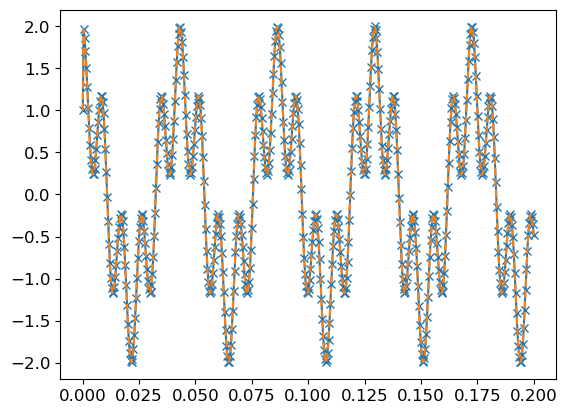

In [31]:
plt.plot(betas, ovlps, 'x-', label='Statevector')
plt.plot(betas, overlap_list, '--', label='Classical')

In [ ]:
plt.plot(wf_list[-2].imag)

In [ ]:
plt.plot(wf_list[2])

In [ ]:
plt.plot(sum_sq)

In [ ]:
plt.plot(betas, E_list)

In [32]:
partition_list = [1]
E_expect = [E_list[0]]
x0_expect = [x0_list[0]]

for m in range(3, numsteps, 2):
    partition = 0
    E = 0
    s = 0
    for k in range(0, m, 2):
        # print(binom(j,int(k/2)))
        # print(wf_root_list[central_index-(j-k)].dag().overlap(wf_root_list[central_index+(j-k)]))
        partition += binom(m, int(k/2)) * ovlps[m-k]
        E += binom(m, int(k/2)) * E_list[m-k]
        s += binom(m, int(k/2)) * x0_list[m-k]
        # print(partition)
    partition = np.abs(partition)
        # norm+=overlap_list[]
    partition_list.append(partition)
    E_expect.append(E/partition)
    x0_expect.append(s/partition)

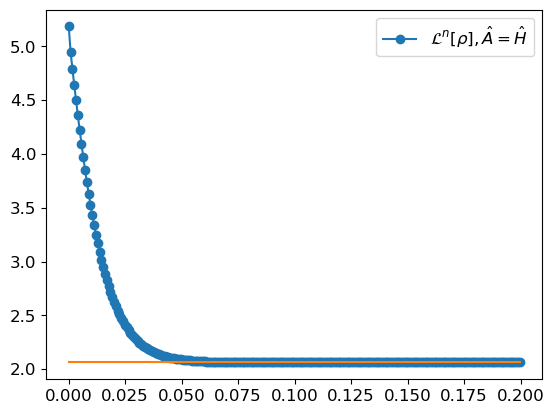

In [33]:
E, V = linalg.eigh(H_qis.to_matrix())
plt.plot(betas[::2], np.array(E_expect).real, 
         'o-', label='$\\mathcal{L}^n[\\rho],\hat{A}=\hat{H}$')
plt.plot(betas[::2], E[0].real * np.ones(len(E_expect)))
plt.savefig("statevector_sim_result.pdf", format='pdf', dpi=300)
plt.legend()

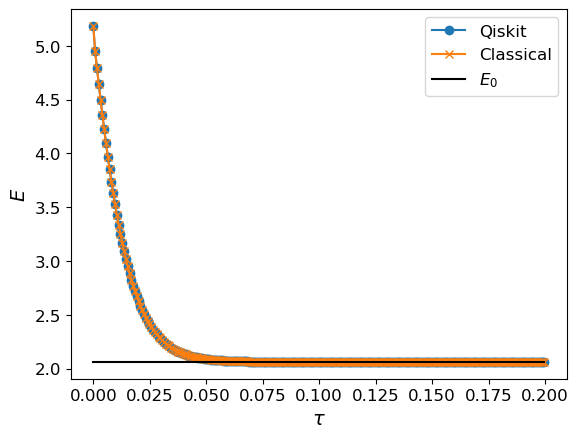

In [34]:
plt.plot(betas[::2], np.array(E_expect).real, 
         'o-', label='Qiskit')
plt.plot(betas[::2], np.array(E_class).real, 'x-', label='Classical')
plt.plot(betas[::2], E[0].real * np.ones(len(E_expect)), 'k-', label='$E_0$')
plt.xlabel("$\\tau$")
plt.ylabel("$E$")
plt.legend()
plt.savefig("statevector_comparison_result.png", format='png', dpi=300)

In [ ]:
plt.plot(betas[::2], x0_expect)